Plots adversary win rate at varying board sizes for the new adversaries in the robustness paper.

In [3]:
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
from tqdm.notebook import tqdm

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col-aaai"),
    ]
)

utils.import_plt_sty("defense-macros.sty")

In [4]:
def get_adv_win_grouped_by_board_size(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = "index == index or index != index",
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by board size.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("board_size")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi


def plot_board_size_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot win rate against different board sizes.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
    """
    fig, ax = plt.subplots(1, 1)

    for df, label in dfs:
        m, l, h = get_adv_win_grouped_by_board_size(df)
        m.plot(label=label)
        ax.fill_between(m.index, l, h, alpha=0.3)

    plt.ylim(-5, 105)
    plt.ylabel("Adversary win \\%")
    plt.xlabel("Board size")
    plt.legend()
    # Integer minor ticks
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))

    return fig, ax

In [5]:
# match directory name, regex matching adversary name in the SGFs, label for the plot
advs = [
    ("gift", "attack-b18", r"\koadvmedium{} vs. \dectwentythree{}"),
    ("continuous", "cont", r"\contadvmedium{} vs. \dectwentythree{}"),
    ("big", "large", r"\largeadvmedium{} vs. \maytwentyfour{}"),
    ("a9", "r9", r"\attackiter{9} vs. \defenseiter{9}"),
    ("atari", "attack-h9", r"\attackhnine{} vs. \defenseiter{9}"),
    ("stall", "attack-ft-h9", r"\stalladv{} vs. \defenseiter{9}"),
    ("vit", "attack-vit", r"\vitadversarymedium{} vs. \vitvictim{}"),
]
dfs = []
for adv_dir, adv_name_regex, label in tqdm(advs):
    df = utils.parse_sgfs([f"/shared/match/board-sizes-241223/{adv_dir}"])
    utils.parse_for_match(df, adv_name_regex=adv_name_regex)
    dfs.append((df, label))

  0%|          | 0/7 [00:00<?, ?it/s]

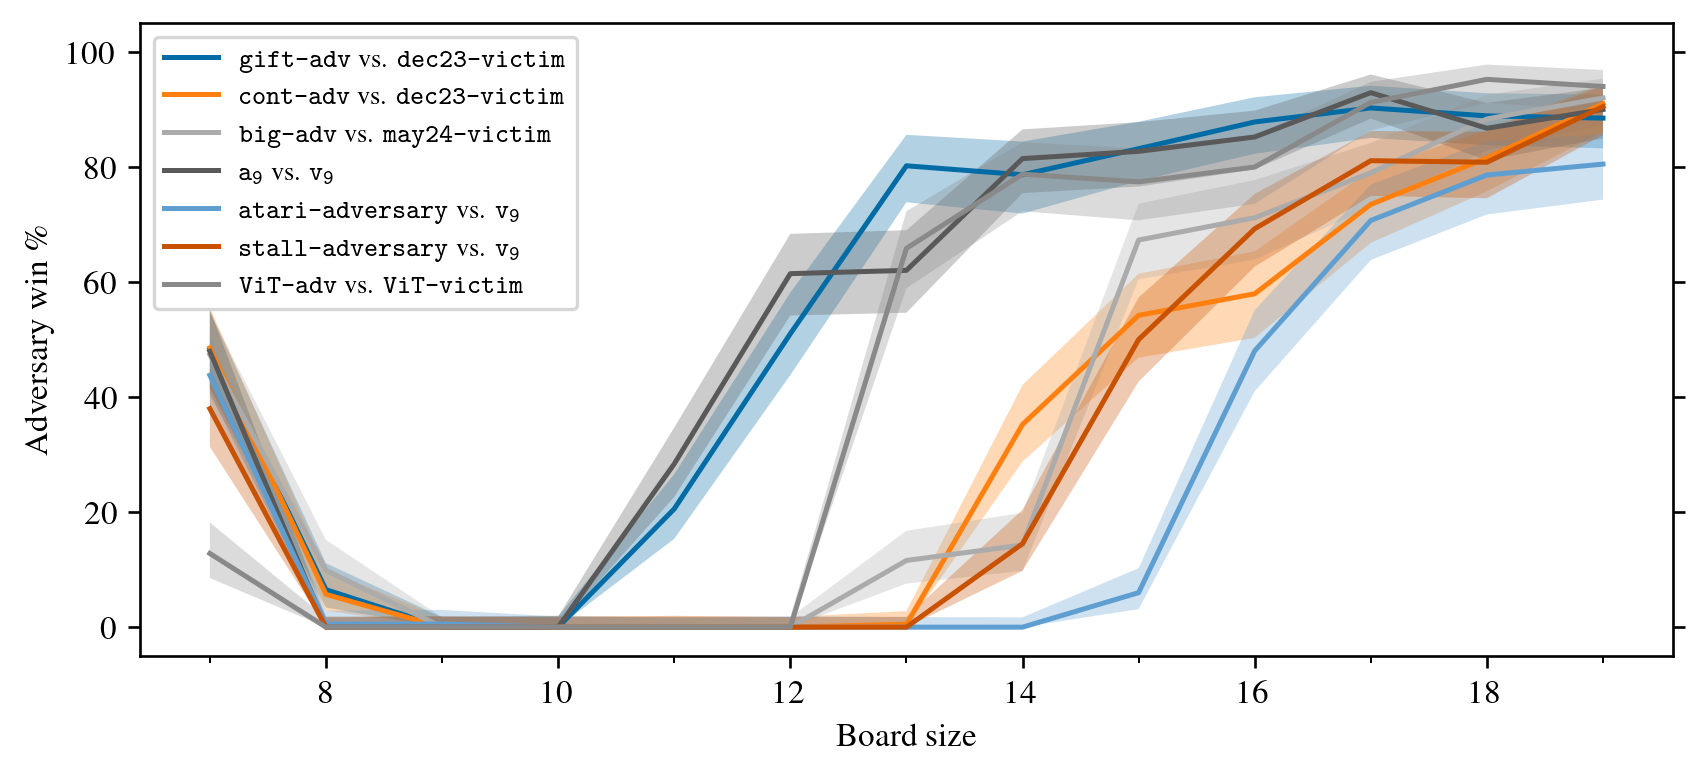

In [6]:
orig_figsize = plt.rcParams["figure.figsize"]
with plt.style.context(
    {
        # This goes in the appendix so we can make it a little taller
        "figure.figsize": (orig_figsize[0], orig_figsize[1] * 1.3),
        "legend.fontsize": 8,
    }
):
    fig, ax = plot_board_size_sweep(dfs)
# I spot checked the 7x7 and 8x8 games, they're not doing cyclic attacks.
# At 11x11 a9 and gift-adv are indeed executing their respective attacks.
fig.savefig("vs-board-size.pgf", backend="pgf", bbox_inches='tight')